# Random Forest regressor

## Authors:
Iuliana Ilie <br>
Benjamin Vega

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import Normalizer

## Load the dataset

### Create Spark Session

In [2]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()

### Load and parse the data file, converting it to a DataFrame.

In [3]:
data = spark_session.read.format("libsvm").load("data_file_AAPL.txt")
print(type(data))

<class 'pyspark.sql.dataframe.DataFrame'>


In [4]:
data.show()

+----------+--------------------+
|     label|            features|
+----------+--------------------+
|115.970001|(10,[0,1,2,3,4,5,...|
|    116.32|(10,[0,1,2,3,4,5,...|
|118.690002|(10,[0,1,2,3,4,5,...|
|119.029999|(10,[0,1,2,3,4,5,...|
|114.949997|(10,[0,1,2,3,4,5,...|
|110.440002|(10,[0,1,2,3,4,5,...|
|108.769997|(10,[0,1,2,3,4,5,...|
|108.860001|(10,[0,1,2,3,4,5,...|
|    115.32|(10,[0,1,2,3,4,5,...|
|111.199997|(10,[0,1,2,3,4,5,...|
|116.599998|(10,[0,1,2,3,4,5,...|
|115.050003|(10,[0,1,2,3,4,5,...|
|115.040001|(10,[0,1,2,3,4,5,...|
|    115.75|(10,[0,1,2,3,4,5,...|
|116.870003|(10,[0,1,2,3,4,5,...|
|117.510002|(10,[0,1,2,3,4,5,...|
|115.980003|(10,[0,1,2,3,4,5,...|
|119.019997|(10,[0,1,2,3,4,5,...|
|120.709999|(10,[0,1,2,3,4,5,...|
|121.190002|(10,[0,1,2,3,4,5,...|
+----------+--------------------+
only showing top 20 rows



## Implement algorithm

### Train-test split of dataset

In [7]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

print(trainingData.show(10))

+--------+--------------------+
|   label|            features|
+--------+--------------------+
|0.115513|(10,[0,1,2,3,4,5,...|
|0.116629|(10,[0,1,2,3,4,5,...|
|0.117188|(10,[0,1,2,3,4,5,...|
|0.117188|(10,[0,1,2,3,4,5,...|
|0.117188|(10,[0,1,2,3,4,5,...|
|0.118304|(10,[0,1,2,3,4,5,...|
|0.118862|(10,[0,1,2,3,4,5,...|
|0.118862|(10,[0,1,2,3,4,5,...|
| 0.12221|(10,[0,1,2,3,4,5,...|
| 0.12221|(10,[0,1,2,3,4,5,...|
+--------+--------------------+
only showing top 10 rows

None


### Create the random forest model

numTrees - Number of trees to train <br>
impurity - Criterion used for information gain calculation <br>
maxDepth - Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. <br>
maxBins - Max number of bins for discretizing continuous features. <br>

In [8]:
rf = RandomForestRegressor(numTrees=15, impurity='variance', maxDepth=10, maxBins=64)

### Train the model

In [9]:
model = rf.fit(trainingData)
model

RandomForestRegressionModel: uid=RandomForestRegressor_66822d60f6fc, numTrees=15, numFeatures=10

### Make predictions.

In [10]:
predictions = model.transform(testData)

In [12]:
# Select example rows to display.
predictions.select("prediction", "label", "features").show(100)

+-------------------+--------+--------------------+
|         prediction|   label|            features|
+-------------------+--------+--------------------+
|0.14103039658314653|0.117746|(10,[0,1,2,3,4,5,...|
|0.14157915194374232|0.117746|(10,[0,1,2,3,4,5,...|
|0.14103039658314653| 0.12221|(10,[0,1,2,3,4,5,...|
|0.14213698290618199|0.122768|(10,[0,1,2,3,4,5,...|
|0.14103039658314653|0.123326|(10,[0,1,2,3,4,5,...|
|0.14103039658314653|0.130022|(10,[0,1,2,3,4,5,...|
|0.14103039658314653|0.131138|(10,[0,1,2,3,4,5,...|
| 0.1407149275796192|0.136161|(10,[0,1,2,3,4,5,...|
|0.14103039658314653|0.136161|(10,[0,1,2,3,4,5,...|
|0.14245245190970932|0.137277|(10,[0,1,2,3,4,5,...|
|0.14213698290618199|0.138393|(10,[0,1,2,3,4,5,...|
| 0.1407149275796192|0.140625|(10,[0,1,2,3,4,5,...|
|0.14213698290618199|0.141183|(10,[0,1,2,3,4,5,...|
| 0.1407149275796192|0.141183|(10,[0,1,2,3,4,5,...|
|0.14281801945063285|0.141741|(10,[0,1,2,3,4,5,...|
|0.14213698290618199|0.142299|(10,[0,1,2,3,4,5,...|
|0.142136982

### Create evaluator to evaluate the prediction results

In [13]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.98906


## Plot the results

In [14]:
#Convert predictions to pandas format in order to plot them
rfResult = predictions.toPandas()
rfResult

nr = range(rfResult.label.count())

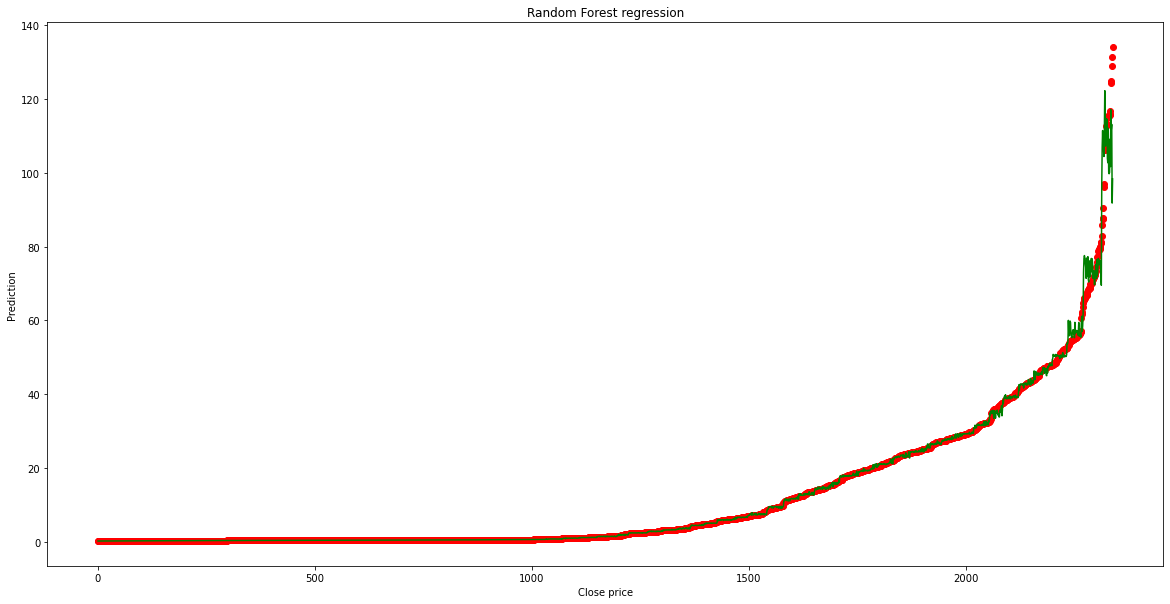

Model RMSE 1.9890627789115463


In [15]:
plt.figure(figsize=(20,10))
plt.scatter(nr, rfResult.label, color = "red")
plt.plot(nr, rfResult.prediction, color = "green")
plt.title("Random Forest regression")
plt.xlabel('Close price')
plt.ylabel('Prediction')

plt.show()

print("Model RMSE", rmse)

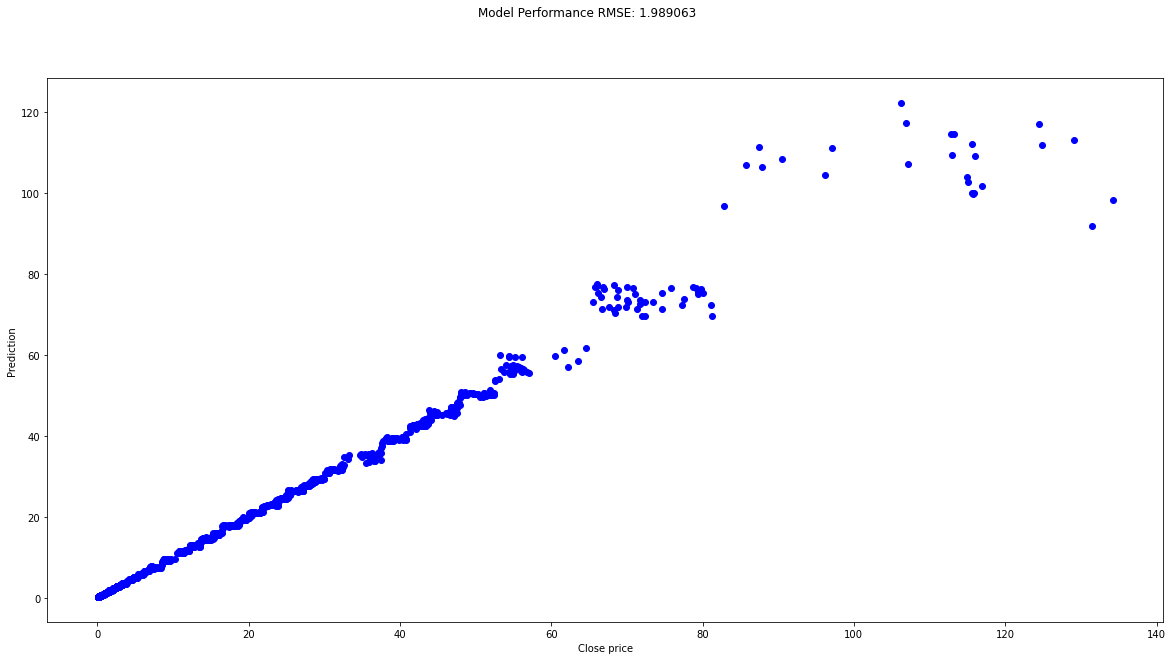

Model RMSE 1.9890627789115463


In [16]:
plt.figure(figsize=(20,10))
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)

plt.show()

print("Model RMSE", rmse)

## Find the best model by implementing Cross-Validation

Create parameter grid with 2 parameters: numTrees and maxDepth each of them having 3 values

In [17]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

estimator: algorithm or Pipeline to tune <br>
estimatorParamMaps: parameters to choose from, sometimes called a “parameter grid” to search over <br>
evaluator: metric to measure how well a fitted Model does on held-out test data

In [18]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

### Train model

In [19]:
cvModel = crossval.fit(trainingData)

### Predict values

In [20]:
# Select the best model
predictions_new = cvModel.transform(testData)

In [21]:
predictions_new.select("prediction", "label", "features").show(10)

+-------------------+--------+--------------------+
|         prediction|   label|            features|
+-------------------+--------+--------------------+
|0.14087813365017632|0.117746|(10,[0,1,2,3,4,5,...|
| 0.1341407389092678|0.117746|(10,[0,1,2,3,4,5,...|
|0.13826385742488095| 0.12221|(10,[0,1,2,3,4,5,...|
|0.13861318494993896|0.122768|(10,[0,1,2,3,4,5,...|
|0.13797334707007664|0.123326|(10,[0,1,2,3,4,5,...|
|0.13964460879392857|0.130022|(10,[0,1,2,3,4,5,...|
| 0.1423353332006382|0.131138|(10,[0,1,2,3,4,5,...|
|0.13482671826320636|0.136161|(10,[0,1,2,3,4,5,...|
|0.13544755055043312|0.136161|(10,[0,1,2,3,4,5,...|
|0.14196790060378509|0.137277|(10,[0,1,2,3,4,5,...|
+-------------------+--------+--------------------+
only showing top 10 rows



## Plot fine tuned prediction data

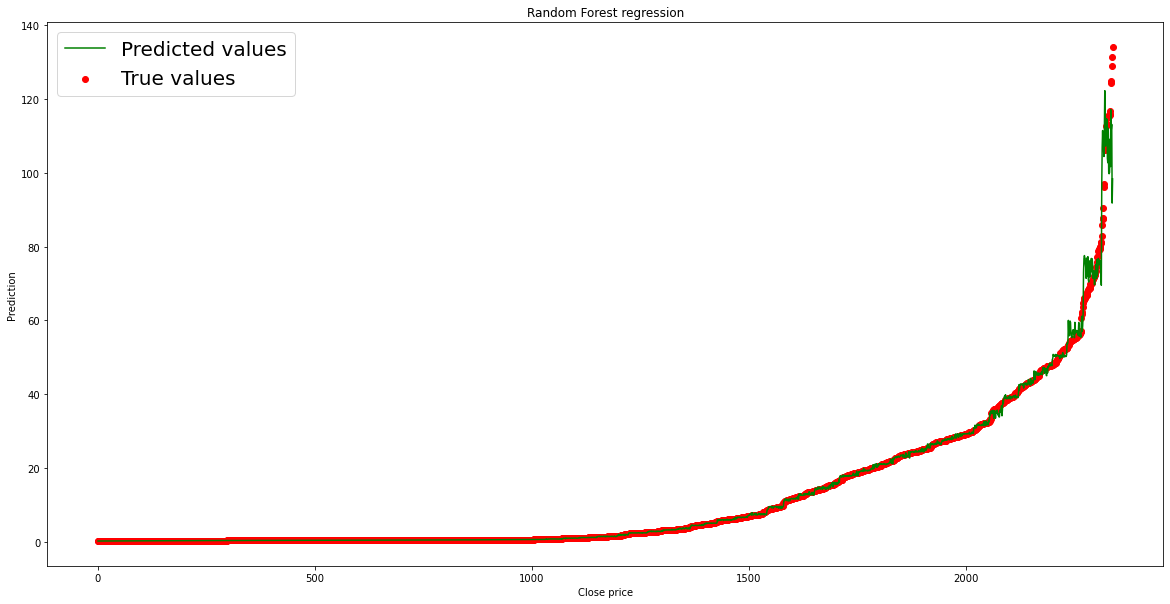

Model RMSE 1.9421223800688392


In [22]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Compute RMSE
rmse = evaluator.evaluate(predictions_new)

# Convert dataset to panda for plotting
rfResult_new = predictions_new.toPandas()
nr_new = range(rfResult_new.label.count())

plt.figure(figsize=(20,10))
plt.scatter(nr_new, rfResult.label, color = "red", label="True values")
plt.plot(nr_new, rfResult.prediction, color = "green", label = "Predicted values")
plt.title("Random Forest regression")
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.legend(prop={'size': 20})
plt.show()

print("Model RMSE", rmse)

## Feature Importance for random forest algorithm

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Text(0.5, 1.0, 'Feature Importances')

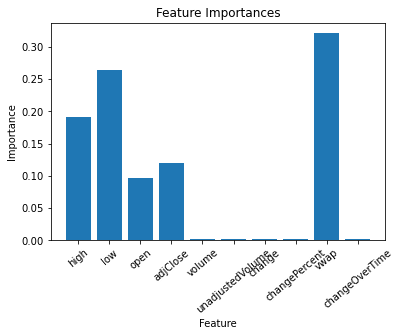

In [23]:
#Select best model
bestModel = cvModel.bestModel

# Extract the important feature values
importances = bestModel.featureImportances

x_values = list(range(len(importances)))
print(x_values)
feature_list = ['high','low','open','adjClose','volume','unadjustedVolume','change','changePercent','vwap','changeOverTime']

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')